<a href="https://colab.research.google.com/github/tahircankzn/DEEP_LEARNING/blob/main/rl0_001_yualse_denge_gray_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Kullanıcının sağladığı Python kodunu, her biri belirli bir işlevi yerine getiren mantıksal hücrelere ayırın.

## Kütüphaneleri ve yardımcı fonksiyonları ayırma

### Subtask:
Gerekli kütüphaneleri yükleyen ve tüm yardımcı fonksiyonları içeren kısmı ayrı bir hücreye taşıyın.


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

**Reasoning**:
The subtask is to separate the imports and helper functions into a new cell. I will move the relevant code from the existing cell into a new code block.



In [ ]:
# ==============================================================================
#                 Gerekli Kütüphaneleri ve Yardımcı Fonksiyonları Yükleme
# ==============================================================================
# Gerekli tüm kütüphaneler bu hücrede toplanmıştır.
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm
import zipfile

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.io import imread

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D,
                                     Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU)
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D,
                                     concatenate, BatchNormalization, Activation,
                                     Dropout, LeakyReLU, add, multiply)
from tensorflow.keras.models import Model


# Google Colab'a özel dosya yükleme modülü
from google.colab import files

import warnings
warnings.filterwarnings("ignore")

print("Tüm modüller başarıyla yüklendi!")
print("TensorFlow Sürümü:", tf.__version__)


# ==============================================================================
#                 TÜM YARDIMCI FONKSİYONLARIN TANIMLANMASI
# ==============================================================================
# Script'teki tüm fonksiyonlar burada tanımlanmıştır.

def create_df(data_dir):
    images_paths = sorted(glob(f'{data_dir}/png/*.png'))
    masks_paths = sorted(glob(f'{data_dir}/mask/*.png'))
    print(f"Bulunan resim sayısı: {len(images_paths)}")
    print(f"Bulunan maske sayısı: {len(masks_paths)}")
    if len(images_paths) != len(masks_paths):
        print("Uyarı: Resim ve maske sayısı eşleşmiyor!")
    df = pd.DataFrame(data={'images_paths': images_paths, 'masks_paths': masks_paths})
    return df

def split_df(df):
    train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=42)
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=42)
    return train_df, valid_df, test_df

def create_gens(df, aug_dict, batch_size):
    img_size = (256, 256)
    img_gen_instance = ImageDataGenerator(**aug_dict)
    msk_gen_instance = ImageDataGenerator(**aug_dict)

    # Renk modunu 'grayscale' yerine 'rgb' olarak değiştir
    image_gen = img_gen_instance.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='grayscale', target_size=img_size, # rgb
                                                    batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1, shuffle=True)
    mask_gen = msk_gen_instance.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                                   batch_size=batch_size, save_to_dir=None, save_prefix='mask', seed=1, shuffle=True)
    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255.0
        msk = msk / 255.0
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0
        yield (img, msk)


def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, (3, 3), padding="same")(inputs)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv1 = Conv2D(64, (3, 3), padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), padding="same")(pool1)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv2 = Conv2D(128, (3, 3), padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), padding="same")(pool2)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = Conv2D(256, (3, 3), padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Bottleneck
    conv4 = Conv2D(512, (3, 3), padding="same")(pool3)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = Conv2D(512, (3, 3), padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = Dropout(0.3)(conv4)
    # Decoder
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, (3, 3), padding="same")(up5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(256, (3, 3), padding="same")(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, (3, 3), padding="same")(up6)
    conv6 = LeakyReLU(alpha=0.1)(conv6)
    conv6 = Conv2D(128, (3, 3), padding="same")(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=0.1)(conv6)
    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, (3, 3), padding="same")(up7)
    conv7 = LeakyReLU(alpha=0.1)(conv7)
    conv7 = Conv2D(64, (3, 3), padding="same")(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = LeakyReLU(alpha=0.1)(conv7)
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(conv7)
    model = Model(inputs, outputs)
    return model


def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return 1 - dice_coef(y_true, y_pred, smooth) # eski : dice_coef(y_true, y_pred, smooth)

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def combo_loss(y_true, y_pred, alpha=0.5, beta=0.5, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    bce = binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred, smooth)
    return alpha * bce + beta * dice

def plot_training(hist):
    # Plot history
    plt.figure(figsize=(20, 12))
    plt.style.use('fivethirtyeight')

    # Metrikleri history objesinden al
    epochs_range = range(1, len(hist.history['loss']) + 1)

    # Kayıp Grafiği
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, hist.history['loss'], label='Training Loss')
    plt.plot(epochs_range, hist.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Dice Coefficient Grafiği
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, hist.history['dice_coef'], label='Training Dice Coef')
    plt.plot(epochs_range, hist.history['val_dice_coef'], label='Validation Dice Coef')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Dice Coefficient')

    # IoU Coefficient Grafiği
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, hist.history['iou_coef'], label='Training IoU Coef')
    plt.plot(epochs_range, hist.history['val_iou_coef'], label='Validation IoU Coef')
    plt.legend(loc='lower right')
    plt.title('Training and Validation IoU Coefficient')

    # Accuracy Grafiği
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, hist.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, hist.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show() # Colab'da doğrudan göstermek için plt.show() kullanıyoruz

Tüm modüller başarıyla yüklendi!
TensorFlow Sürümü: 2.18.0


## Veri yükleme ve hazırlama kısmını ayırma

### Subtask:
Zip dosyasını yükleme, çıkarma ve DataFrame oluşturma adımlarını ayrı bir hücreye taşıyın.


**Reasoning**:
Move the code for loading and extracting the zip file, and creating the initial DataFrame to a new cell as per the instructions.



In [ ]:
# ==============================================================================
#                         Veri Yükleme ve Hazırlık
# ==============================================================================

# 1. VERİ YÜKLEME VE HAZIRLAMA
zip_file_name = 'inme_t_f_new.zip'
extract_base_dir = 'data2'
data_folder_name_in_zip = 'inme_t_f_new'

# Colab'a dosya yükleme
if not os.path.exists(zip_file_name):
    print(f"'{zip_file_name}' dosyası bulunamadı. Lütfen şimdi yükleyin.")
    uploaded = files.upload()
    if zip_file_name not in uploaded:
        print(f"Hata: '{zip_file_name}' dosyası yüklenmedi. Script durduruluyor.")
    else:
        print(f"'{zip_file_name}' başarıyla yüklendi.")
else:
    print(f"'{zip_file_name}' dosyası zaten mevcut.")

# Zip dosyasını çıkarma
data_dir = os.path.join(extract_base_dir, data_folder_name_in_zip)
if not os.path.exists(data_dir):
    print(f"'{data_dir}' bulunamadı. Zip dosyası çıkarılıyor...")
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(extract_base_dir)
    print("Zip dosyası başarıyla çıkarıldı.")
else:
    print(f"Veri klasörü '{data_dir}' zaten mevcut. Çıkarma işlemi atlanıyor.")

# 2. VERİ SETİNİ OKUMA
df = create_df(data_dir)
if df.empty:
    print("DataFrame boş. Script durduruluyor.")
else:
    print(f"DataFrame boyutu: {df.shape}")




'inme_t_f_new.zip' dosyası bulunamadı. Lütfen şimdi yükleyin.


Saving inme_t_f_new.zip to inme_t_f_new.zip
'inme_t_f_new.zip' başarıyla yüklendi.
'data2/inme_t_f_new' bulunamadı. Zip dosyası çıkarılıyor...
Zip dosyası başarıyla çıkarıldı.
Bulunan resim sayısı: 2254
Bulunan maske sayısı: 2254
DataFrame boyutu: (2254, 2)


## Veri bölme ve üreteçleri ayırma

### Subtask:
DataFrame'i eğitim, doğrulama ve test setlerine bölme ve veri üreteçlerini oluşturma adımlarını ayrı bir hücreye taşıyın.


**Reasoning**:
Move the code for splitting the DataFrame, defining data augmentation, hyperparameters, and creating data generators into a new cell.



In [ ]:
# ==============================================================================
#               Veri Setini Bölme ve Veri Üreteçlerini Oluşturma
# ==============================================================================

# 2. VERİ SETİNİ BÖLME
if not df.empty:
    train_df, valid_df, test_df = split_df(df)
    print(f"Train: {train_df.shape}, Valid: {valid_df.shape}, Test: {test_df.shape}")

    # 3. VERİ ÜRETEÇLERİ (GENERATORS) VE ARTIRMA (AUGMENTATION)
    tr_aug_dict = dict(rotation_range=0.2,
                       width_shift_range=0.05,
                       height_shift_range=0.05,
                       shear_range=0.05,
                       zoom_range=0.05,
                       horizontal_flip=True,
                       fill_mode='nearest')

    # Hiperparametreler
    batch_size = 64
    epochs = 500 # Keep epochs definition here as it's used later in model fitting
    learning_rate = 0.001 # Keep learning_rate definition here as it's used later in model compilation

    train_gen = create_gens(train_df, aug_dict=tr_aug_dict, batch_size=batch_size)
    valid_gen = create_gens(valid_df, aug_dict={}, batch_size=batch_size)
else:
    print("DataFrame boş olduğu için bölme ve üreteç oluşturma adımları atlanıyor.")

Train: (1803, 2), Valid: (225, 2), Test: (226, 2)


## Model oluşturma ve derleme kısmını ayırma

### Subtask:
U-Net modelini tanımlama ve derleme adımlarını ayrı bir hücreye taşıyın.


**Reasoning**:
Create a new code cell with the specified title and move the U-Net model definition and compilation steps into it. Ensure necessary variables like `batch_size` and `learning_rate` are available (they are defined in the previous successful step).



In [ ]:
# ==============================================================================
#                       Model Oluşturma ve Derleme
# ==============================================================================

# 4. MODELİ OLUŞTURMA VE DERLEME
print("\nU-Net modeli oluşturuluyor...")
model = unet()

# Önerilen değişiklikler: Combo Loss ve Adam optimizer
optimizer = Adamax(learning_rate=learning_rate)
loss_function = combo_loss

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', iou_coef, dice_coef])
model.summary()


U-Net modeli oluşturuluyor...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ leaky_re_lu_4[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 7,701,825 (29.38 MB)

 Trainable params: 7,699,009 (29.37 MB)

 Non-trainable params: 2,816 (11.00 KB)

**Reasoning**:
The previous command failed because `learning_rate` was not defined in the new cell. Need to include the definition of `learning_rate` and `batch_size` in this cell as they are hyperparameters used here and in subsequent training steps.



**Reasoning**:
The model creation and compilation step was successful. The next logical step according to the original script flow is to define and set up the callbacks for the model training.



In [ ]:
# ==============================================================================
#                           Callback'leri Tanımlama
# ==============================================================================

# 5. CALLBACK'LERİ TANIMLAMA
# Önerilen değişiklik: Daha sabırlı bir EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('unet_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [reduce_lr, early_stop, model_checkpoint]

print("\nCallback'ler tanımlandı.")


Callback'ler tanımlandı.


**Reasoning**:
The callbacks have been defined. The next step is to train the model using the defined generators, hyperparameters, and callbacks.



In [ ]:
# ==============================================================================
#                                Model Eğitimi
# ==============================================================================

# 6. MODEL EĞİTİMİ
steps_per_epoch = max(1, len(train_df) // batch_size)
validation_steps = max(1, len(valid_df) // batch_size)

print(f"\nModel eğitimi başlıyor...")
print(f"Epoch: {epochs}, Batch Size: {batch_size}, Learning Rate: {learning_rate}")

history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=valid_gen,
                    validation_steps=validation_steps)


Model eğitimi başlıyor...
Epoch: 500, Batch Size: 64, Learning Rate: 0.001
Found 1803 validated image filenames.
Found 1803 validated image filenames.
Epoch 1/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.8916 - dice_coef: 0.0228 - iou_coef: 0.0170 - loss: 0.6794Found 225 validated image filenames.
Found 225 validated image filenames.

Epoch 1: val_loss improved from inf to 0.78545, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 813ms/step - accuracy: 0.8938 - dice_coef: 0.0228 - iou_coef: 0.0170 - loss: 0.6773 - val_accuracy: 0.8306 - val_dice_coef: 0.0178 - val_iou_coef: 0.0121 - val_loss: 0.7855 - learning_rate: 0.0010
Epoch 2/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9899 - dice_coef: 0.0234 - iou_coef: 0.0233 - loss: 0.5572
Epoch 2: val_loss improved from 0.78545 to 0.71108, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 36s 719ms/step - accuracy: 0.9899 - dice_coef: 0.0235 - iou_coef: 0.0234 - loss: 0.5570 - val_accuracy: 0.9914 - val_dice_coef: 0.0159 - val_iou_coef: 0.0118 - val_loss: 0.7111 - learning_rate: 0.0010
Epoch 3/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9865 - dice_coef: 0.0409 - iou_coef: 0.0324 - loss: 0.5379
Epoch 3: val_loss improved from 0.71108 to 0.66031, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 735ms/step - accuracy: 0.9863 - dice_coef: 0.0415 - iou_coef: 0.0326 - loss: 0.5376 - val_accuracy: 0.9926 - val_dice_coef: 0.0148 - val_iou_coef: 0.0121 - val_loss: 0.6603 - learning_rate: 0.0010
Epoch 4/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9815 - dice_coef: 0.0601 - iou_coef: 0.0408 - loss: 0.5211
Epoch 4: val_loss improved from 0.66031 to 0.61121, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 975ms/step - accuracy: 0.9814 - dice_coef: 0.0609 - iou_coef: 0.0411 - loss: 0.5207 - val_accuracy: 0.9915 - val_dice_coef: 0.0180 - val_iou_coef: 0.0151 - val_loss: 0.6112 - learning_rate: 0.0010
Epoch 5/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9720 - dice_coef: 0.1232 - iou_coef: 0.0665 - loss: 0.4850
Epoch 5: val_loss improved from 0.61121 to 0.57198, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 687ms/step - accuracy: 0.9721 - dice_coef: 0.1236 - iou_coef: 0.0667 - loss: 0.4848 - val_accuracy: 0.9914 - val_dice_coef: 0.0131 - val_iou_coef: 0.0166 - val_loss: 0.5720 - learning_rate: 0.0010
Epoch 6/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9718 - dice_coef: 0.1480 - iou_coef: 0.0792 - loss: 0.4703
Epoch 6: val_loss improved from 0.57198 to 0.55197, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 729ms/step - accuracy: 0.9719 - dice_coef: 0.1485 - iou_coef: 0.0794 - loss: 0.4699 - val_accuracy: 0.9917 - val_dice_coef: 0.0125 - val_iou_coef: 0.0206 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 7/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9780 - dice_coef: 0.1610 - iou_coef: 0.0877 - loss: 0.4555
Epoch 7: val_loss improved from 0.55197 to 0.54290, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 731ms/step - accuracy: 0.9781 - dice_coef: 0.1620 - iou_coef: 0.0881 - loss: 0.4549 - val_accuracy: 0.9917 - val_dice_coef: 0.0107 - val_iou_coef: 0.0244 - val_loss: 0.5429 - learning_rate: 0.0010
Epoch 8/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9806 - dice_coef: 0.1919 - iou_coef: 0.1086 - loss: 0.4336
Epoch 8: val_loss improved from 0.54290 to 0.53298, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 715ms/step - accuracy: 0.9806 - dice_coef: 0.1930 - iou_coef: 0.1090 - loss: 0.4330 - val_accuracy: 0.9912 - val_dice_coef: 0.0116 - val_iou_coef: 0.0332 - val_loss: 0.5330 - learning_rate: 0.0010
Epoch 9/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9829 - dice_coef: 0.2348 - iou_coef: 0.1326 - loss: 0.4097
Epoch 9: val_loss improved from 0.53298 to 0.52671, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 728ms/step - accuracy: 0.9830 - dice_coef: 0.2363 - iou_coef: 0.1332 - loss: 0.4089 - val_accuracy: 0.9918 - val_dice_coef: 0.0085 - val_iou_coef: 0.0486 - val_loss: 0.5267 - learning_rate: 0.0010
Epoch 10/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9823 - dice_coef: 0.2525 - iou_coef: 0.1566 - loss: 0.4031
Epoch 10: val_loss did not improve from 0.52671
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - accuracy: 0.9824 - dice_coef: 0.2538 - iou_coef: 0.1571 - loss: 0.4023 - val_accuracy: 0.9918 - val_dice_coef: 0.0071 - val_iou_coef: 0.0515 - val_loss: 0.5277 - learning_rate: 0.0010
Epoch 11/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.9844 - dice_coef: 0.2952 - iou_coef: 0.1862 - loss: 0.3763
Epoch 11: val_loss improved from 0.52671 to 0.52270, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 751ms/step - accuracy: 0.9845 - dice_coef: 0.2962 - iou_coef: 0.1868 - loss: 0.3757 - val_accuracy: 0.9922 - val_dice_coef: 0.0071 - val_iou_coef: 0.0780 - val_loss: 0.5227 - learning_rate: 0.0010
Epoch 12/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.9863 - dice_coef: 0.3188 - iou_coef: 0.2176 - loss: 0.3690
Epoch 12: val_loss did not improve from 0.52270
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 704ms/step - accuracy: 0.9863 - dice_coef: 0.3203 - iou_coef: 0.2183 - loss: 0.3681 - val_accuracy: 0.9907 - val_dice_coef: 0.0066 - val_iou_coef: 0.0957 - val_loss: 0.5269 - learning_rate: 0.0010
Epoch 13/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9841 - dice_coef: 0.3387 - iou_coef: 0.2545 - loss: 0.3588
Epoch 13: val_loss did not improve from 0.52270
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 725ms/step - accuracy: 0.9842 - dice_coef: 0.3402 - iou_coef: 0.2551 - loss: 0.3579 - val_accuracy: 0.9908 - val_dice_coef: 0.0110 - val_iou_coef: 0.1279 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 754ms/step - accuracy: 0.9883 - dice_coef: 0.3633 - iou_coef: 0.2901 - loss: 0.3426 - val_accuracy: 0.9919 - val_dice_coef: 0.0066 - val_iou_coef: 0.1738 - val_loss: 0.5217 - learning_rate: 0.0010
Epoch 15/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9875 - dice_coef: 0.3784 - iou_coef: 0.3228 - loss: 0.3356
Epoch 15: val_loss improved from 0.52165 to 0.51746, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.9875 - dice_coef: 0.3800 - iou_coef: 0.3233 - loss: 0.3347 - val_accuracy: 0.9914 - val_dice_coef: 0.0169 - val_iou_coef: 0.1984 - val_loss: 0.5175 - learning_rate: 0.0010
Epoch 16/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9873 - dice_coef: 0.3949 - iou_coef: 0.3478 - loss: 0.3300
Epoch 16: val_loss improved from 0.51746 to 0.48327, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 726ms/step - accuracy: 0.9874 - dice_coef: 0.3964 - iou_coef: 0.3485 - loss: 0.3292 - val_accuracy: 0.9915 - val_dice_coef: 0.0854 - val_iou_coef: 0.2824 - val_loss: 0.4833 - learning_rate: 0.0010
Epoch 17/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.9892 - dice_coef: 0.4060 - iou_coef: 0.3859 - loss: 0.3221
Epoch 17: val_loss did not improve from 0.48327
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 726ms/step - accuracy: 0.9892 - dice_coef: 0.4078 - iou_coef: 0.3867 - loss: 0.3212 - val_accuracy: 0.9914 - val_dice_coef: 0.0048 - val_iou_coef: 0.2330 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 18/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.9889 - dice_coef: 0.4220 - iou_coef: 0.4050 - loss: 0.3086
Epoch 18: val_loss improved from 0.48327 to 0.41829, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 741ms/step - accuracy: 0.9889 - dice_coef: 0.4230 - iou_coef: 0.4055 - loss: 0.3079 - val_accuracy: 0.9922 - val_dice_coef: 0.2050 - val_iou_coef: 0.2900 - val_loss: 0.4183 - learning_rate: 0.0010
Epoch 19/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9888 - dice_coef: 0.4265 - iou_coef: 0.4413 - loss: 0.3127
Epoch 19: val_loss improved from 0.41829 to 0.40357, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 731ms/step - accuracy: 0.9889 - dice_coef: 0.4286 - iou_coef: 0.4420 - loss: 0.3115 - val_accuracy: 0.9906 - val_dice_coef: 0.2404 - val_iou_coef: 0.3348 - val_loss: 0.4036 - learning_rate: 0.0010
Epoch 20/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9890 - dice_coef: 0.4453 - iou_coef: 0.4599 - loss: 0.3008
Epoch 20: val_loss improved from 0.40357 to 0.34454, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 714ms/step - accuracy: 0.9890 - dice_coef: 0.4465 - iou_coef: 0.4606 - loss: 0.3000 - val_accuracy: 0.9828 - val_dice_coef: 0.3794 - val_iou_coef: 0.4264 - val_loss: 0.3445 - learning_rate: 0.0010
Epoch 21/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9903 - dice_coef: 0.4726 - iou_coef: 0.4799 - loss: 0.2851
Epoch 21: val_loss did not improve from 0.34454
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 722ms/step - accuracy: 0.9903 - dice_coef: 0.4735 - iou_coef: 0.4805 - loss: 0.2846 - val_accuracy: 0.9928 - val_dice_coef: 0.2377 - val_iou_coef: 0.4374 - val_loss: 0.3999 - learning_rate: 0.0010
Epoch 22/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.9907 - dice_coef: 0.4752 - iou_coef: 0.5011 - loss: 0.2840
Epoch 22: val_loss improved from 0.34454 to 0.24966, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 743ms/step - accuracy: 0.9907 - dice_coef: 0.4771 - iou_coef: 0.5017 - loss: 0.2830 - val_accuracy: 0.9941 - val_dice_coef: 0.5271 - val_iou_coef: 0.5399 - val_loss: 0.2497 - learning_rate: 0.0010
Epoch 23/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9899 - dice_coef: 0.4607 - iou_coef: 0.5093 - loss: 0.2945
Epoch 23: val_loss improved from 0.24966 to 0.24557, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.9899 - dice_coef: 0.4627 - iou_coef: 0.5101 - loss: 0.2934 - val_accuracy: 0.9939 - val_dice_coef: 0.5351 - val_iou_coef: 0.5688 - val_loss: 0.2456 - learning_rate: 0.0010
Epoch 24/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.9904 - dice_coef: 0.4831 - iou_coef: 0.5365 - loss: 0.2814
Epoch 24: val_loss improved from 0.24557 to 0.24441, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 737ms/step - accuracy: 0.9904 - dice_coef: 0.4855 - iou_coef: 0.5374 - loss: 0.2801 - val_accuracy: 0.9923 - val_dice_coef: 0.5513 - val_iou_coef: 0.5847 - val_loss: 0.2444 - learning_rate: 0.0010
Epoch 25/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9901 - dice_coef: 0.4965 - iou_coef: 0.5479 - loss: 0.2750
Epoch 25: val_loss did not improve from 0.24441
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 739ms/step - accuracy: 0.9901 - dice_coef: 0.4977 - iou_coef: 0.5486 - loss: 0.2741 - val_accuracy: 0.9936 - val_dice_coef: 0.3340 - val_iou_coef: 0.5352 - val_loss: 0.3518 - learning_rate: 0.0010
Epoch 26/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.9907 - dice_coef: 0.5044 - iou_coef: 0.5706 - loss: 0.2708
Epoch 26: val_loss did not improve from 0.24441
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 737ms/step - accuracy: 0.9907 - dice_coef: 0.5063 - iou_coef: 0.5710 - loss: 0.2698 - val_accuracy: 0.9939 - val_dice_coef: 0.4691 - val_iou_coef: 0.5404 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 729ms/step - accuracy: 0.9894 - dice_coef: 0.4574 - iou_coef: 0.5586 - loss: 0.2989 - val_accuracy: 0.9926 - val_dice_coef: 0.5656 - val_iou_coef: 0.5731 - val_loss: 0.2376 - learning_rate: 0.0010
Epoch 29/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9909 - dice_coef: 0.5065 - iou_coef: 0.5955 - loss: 0.2696
Epoch 29: val_loss did not improve from 0.23760
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 724ms/step - accuracy: 0.9909 - dice_coef: 0.5083 - iou_coef: 0.5960 - loss: 0.2687 - val_accuracy: 0.9920 - val_dice_coef: 0.4859 - val_iou_coef: 0.4767 - val_loss: 0.2748 - learning_rate: 0.0010
Epoch 30/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.9907 - dice_coef: 0.5088 - iou_coef: 0.5942 - loss: 0.2694
Epoch 30: val_loss did not improve from 0.23760
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 758ms/step - accuracy: 0.9908 - dice_coef: 0.5109 - iou_coef: 0.5950 - loss: 0.2681 - val_accuracy: 0.9916 - val_dice_coef: 0.3829 - val_iou_coef: 0.4552 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 742ms/step - accuracy: 0.9926 - dice_coef: 0.5387 - iou_coef: 0.6493 - loss: 0.2571 - val_accuracy: 0.9929 - val_dice_coef: 0.5812 - val_iou_coef: 0.6517 - val_loss: 0.2261 - learning_rate: 0.0010
Epoch 36/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9919 - dice_coef: 0.5365 - iou_coef: 0.6447 - loss: 0.2563
Epoch 36: val_loss did not improve from 0.22614
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 715ms/step - accuracy: 0.9919 - dice_coef: 0.5387 - iou_coef: 0.6452 - loss: 0.2550 - val_accuracy: 0.9942 - val_dice_coef: 0.5045 - val_iou_coef: 0.6431 - val_loss: 0.2708 - learning_rate: 0.0010
Epoch 37/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9907 - dice_coef: 0.5042 - iou_coef: 0.6230 - loss: 0.2691
Epoch 37: val_loss did not improve from 0.22614
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 735ms/step - accuracy: 0.9907 - dice_coef: 0.5067 - iou_coef: 0.6240 - loss: 0.2676 - val_accuracy: 0.9659 - val_dice_coef: 0.1830 - val_iou_coef: 0.2959 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.9916 - dice_coef: 0.5053 - iou_coef: 0.6380 - loss: 0.2728 - val_accuracy: 0.9947 - val_dice_coef: 0.5877 - val_iou_coef: 0.6223 - val_loss: 0.2199 - learning_rate: 0.0010
Epoch 40/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9914 - dice_coef: 0.5318 - iou_coef: 0.6461 - loss: 0.2580
Epoch 40: val_loss did not improve from 0.21988
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 705ms/step - accuracy: 0.9914 - dice_coef: 0.5348 - iou_coef: 0.6470 - loss: 0.2562 - val_accuracy: 0.9905 - val_dice_coef: 0.5302 - val_iou_coef: 0.6164 - val_loss: 0.2600 - learning_rate: 0.0010
Epoch 41/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9908 - dice_coef: 0.5178 - iou_coef: 0.6464 - loss: 0.2673
Epoch 41: val_loss did not improve from 0.21988
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 747ms/step - accuracy: 0.9909 - dice_coef: 0.5205 - iou_coef: 0.6473 - loss: 0.2657 - val_accuracy: 0.9946 - val_dice_coef: 0.5773 - val_iou_coef: 0.6597 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 748ms/step - accuracy: 0.9927 - dice_coef: 0.5734 - iou_coef: 0.6769 - loss: 0.2345 - val_accuracy: 0.9944 - val_dice_coef: 0.6164 - val_iou_coef: 0.6721 - val_loss: 0.2049 - learning_rate: 0.0010
Epoch 46/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9923 - dice_coef: 0.5615 - iou_coef: 0.6685 - loss: 0.2415
Epoch 46: val_loss did not improve from 0.20486
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 710ms/step - accuracy: 0.9924 - dice_coef: 0.5637 - iou_coef: 0.6692 - loss: 0.2402 - val_accuracy: 0.9943 - val_dice_coef: 0.5926 - val_iou_coef: 0.6536 - val_loss: 0.2187 - learning_rate: 0.0010
Epoch 47/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9921 - dice_coef: 0.5665 - iou_coef: 0.6818 - loss: 0.2384
Epoch 47: val_loss did not improve from 0.20486
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 718ms/step - accuracy: 0.9921 - dice_coef: 0.5689 - iou_coef: 0.6825 - loss: 0.2370 - val_accuracy: 0.9939 - val_dice_coef: 0.5483 - val_iou_coef: 0.6180 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.9923 - dice_coef: 0.5615 - iou_coef: 0.6771 - loss: 0.2414 - val_accuracy: 0.9945 - val_dice_coef: 0.6191 - val_iou_coef: 0.6897 - val_loss: 0.2045 - learning_rate: 0.0010
Epoch 53/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9926 - dice_coef: 0.5446 - iou_coef: 0.6884 - loss: 0.2468
Epoch 53: val_loss did not improve from 0.20452
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - accuracy: 0.9926 - dice_coef: 0.5478 - iou_coef: 0.6893 - loss: 0.2449 - val_accuracy: 0.9946 - val_dice_coef: 0.5908 - val_iou_coef: 0.6795 - val_loss: 0.2191 - learning_rate: 0.0010
Epoch 54/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9925 - dice_coef: 0.5919 - iou_coef: 0.6853 - loss: 0.2248
Epoch 54: val_loss did not improve from 0.20452
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 723ms/step - accuracy: 0.9925 - dice_coef: 0.5941 - iou_coef: 0.6862 - loss: 0.2235 - val_accuracy: 0.9940 - val_dice_coef: 0.5448 - val_iou_coef: 0.6536 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 735ms/step - accuracy: 0.9932 - dice_coef: 0.6040 - iou_coef: 0.7119 - loss: 0.2174 - val_accuracy: 0.9938 - val_dice_coef: 0.6478 - val_iou_coef: 0.7011 - val_loss: 0.1910 - learning_rate: 0.0010
Epoch 56/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.9930 - dice_coef: 0.6050 - iou_coef: 0.7014 - loss: 0.2178
Epoch 56: val_loss did not improve from 0.19099
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 719ms/step - accuracy: 0.9931 - dice_coef: 0.6073 - iou_coef: 0.7024 - loss: 0.2166 - val_accuracy: 0.9948 - val_dice_coef: 0.5792 - val_iou_coef: 0.7013 - val_loss: 0.2153 - learning_rate: 0.0010
Epoch 57/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9924 - dice_coef: 0.5926 - iou_coef: 0.6831 - loss: 0.2267
Epoch 57: val_loss improved from 0.19099 to 0.18030, saving model to unet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 734ms/step - accuracy: 0.9924 - dice_coef: 0.5952 - iou_coef: 0.6844 - loss: 0.2252 - val_accuracy: 0.9943 - val_dice_coef: 0.6685 - val_iou_coef: 0.7177 - val_loss: 0.1803 - learning_rate: 0.0010
Epoch 58/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9925 - dice_coef: 0.5861 - iou_coef: 0.6877 - loss: 0.2281
Epoch 58: val_loss did not improve from 0.18030
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 707ms/step - accuracy: 0.9925 - dice_coef: 0.5885 - iou_coef: 0.6887 - loss: 0.2267 - val_accuracy: 0.9940 - val_dice_coef: 0.6579 - val_iou_coef: 0.7109 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 59/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.9932 - dice_coef: 0.5742 - iou_coef: 0.7076 - loss: 0.2332
Epoch 59: val_loss did not improve from 0.18030
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 753ms/step - accuracy: 0.9932 - dice_coef: 0.5769 - iou_coef: 0.7080 - loss: 0.2317 - val_accuracy: 0.9939 - val_dice_coef: 0.6223 - val_iou_coef: 0.6992 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 742ms/step - accuracy: 0.9925 - dice_coef: 0.5572 - iou_coef: 0.6728 - loss: 0.2392 - val_accuracy: 0.9952 - val_dice_coef: 0.6711 - val_iou_coef: 0.7254 - val_loss: 0.1772 - learning_rate: 0.0010
Epoch 62/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9925 - dice_coef: 0.6002 - iou_coef: 0.6960 - loss: 0.2240
Epoch 62: val_loss did not improve from 0.17719
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - accuracy: 0.9926 - dice_coef: 0.6022 - iou_coef: 0.6969 - loss: 0.2228 - val_accuracy: 0.9949 - val_dice_coef: 0.6566 - val_iou_coef: 0.7162 - val_loss: 0.1849 - learning_rate: 0.0010
Epoch 63/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.9921 - dice_coef: 0.6024 - iou_coef: 0.6979 - loss: 0.2261
Epoch 63: val_loss did not improve from 0.17719
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 728ms/step - accuracy: 0.9921 - dice_coef: 0.6050 - iou_coef: 0.6991 - loss: 0.2244 - val_accuracy: 0.9945 - val_dice_coef: 0.6499 - val_iou_coef: 0.7080 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 740ms/step - accuracy: 0.9921 - dice_coef: 0.6087 - iou_coef: 0.6950 - loss: 0.2196 - val_accuracy: 0.9957 - val_dice_coef: 0.7223 - val_iou_coef: 0.7378 - val_loss: 0.1545 - learning_rate: 0.0010
Epoch 65/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9926 - dice_coef: 0.5824 - iou_coef: 0.7016 - loss: 0.2351
Epoch 65: val_loss did not improve from 0.15453
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 740ms/step - accuracy: 0.9926 - dice_coef: 0.5851 - iou_coef: 0.7023 - loss: 0.2335 - val_accuracy: 0.9803 - val_dice_coef: 0.3309 - val_iou_coef: 0.4473 - val_loss: 0.3742 - learning_rate: 0.0010
Epoch 66/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.9926 - dice_coef: 0.5926 - iou_coef: 0.7045 - loss: 0.2261
Epoch 66: val_loss did not improve from 0.15453
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 741ms/step - accuracy: 0.9926 - dice_coef: 0.5951 - iou_coef: 0.7055 - loss: 0.2246 - val_accuracy: 0.9779 - val_dice_coef: 0.3333 - val_iou_coef: 0.3811 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 741ms/step - accuracy: 0.9928 - dice_coef: 0.6501 - iou_coef: 0.7332 - loss: 0.1977 - val_accuracy: 0.9954 - val_dice_coef: 0.7176 - val_iou_coef: 0.7274 - val_loss: 0.1527 - learning_rate: 5.0000e-04
Epoch 83/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9940 - dice_coef: 0.6596 - iou_coef: 0.7418 - loss: 0.1881
Epoch 83: val_loss did not improve from 0.15266
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 707ms/step - accuracy: 0.9941 - dice_coef: 0.6620 - iou_coef: 0.7426 - loss: 0.1868 - val_accuracy: 0.9945 - val_dice_coef: 0.6693 - val_iou_coef: 0.7151 - val_loss: 0.1811 - learning_rate: 5.0000e-04
Epoch 84/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9930 - dice_coef: 0.6082 - iou_coef: 0.7252 - loss: 0.2179
Epoch 84: val_loss did not improve from 0.15266
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 715ms/step - accuracy: 0.9931 - dice_coef: 0.6121 - iou_coef: 0.7266 - loss: 0.2157 - val_accuracy: 0.9960 - val_dice_coef: 0.6969 - val_iou_coef: 0.7679 -

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 739ms/step - accuracy: 0.9940 - dice_coef: 0.6572 - iou_coef: 0.7547 - loss: 0.1890 - val_accuracy: 0.9958 - val_dice_coef: 0.7237 - val_iou_coef: 0.7557 - val_loss: 0.1490 - learning_rate: 5.0000e-04
Epoch 87/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9924 - dice_coef: 0.6348 - iou_coef: 0.7189 - loss: 0.2055
Epoch 87: val_loss did not improve from 0.14895
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 715ms/step - accuracy: 0.9925 - dice_coef: 0.6378 - iou_coef: 0.7203 - loss: 0.2038 - val_accuracy: 0.9952 - val_dice_coef: 0.6345 - val_iou_coef: 0.7235 - val_loss: 0.1965 - learning_rate: 5.0000e-04
Epoch 88/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.9927 - dice_coef: 0.6465 - iou_coef: 0.7276 - loss: 0.2002
Epoch 88: val_loss did not improve from 0.14895
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 737ms/step - accuracy: 0.9927 - dice_coef: 0.6495 - iou_coef: 0.7289 - loss: 0.1984 - val_accuracy: 0.9958 - val_dice_coef: 0.7093 - val_iou_coef: 0.7567 -

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 741ms/step - accuracy: 0.9940 - dice_coef: 0.6827 - iou_coef: 0.7675 - loss: 0.1779 - val_accuracy: 0.9962 - val_dice_coef: 0.7347 - val_iou_coef: 0.7761 - val_loss: 0.1465 - learning_rate: 1.2500e-04
Epoch 109/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9944 - dice_coef: 0.7047 - iou_coef: 0.7760 - loss: 0.1645
Epoch 109: val_loss did not improve from 0.14652
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 720ms/step - accuracy: 0.9945 - dice_coef: 0.7069 - iou_coef: 0.7765 - loss: 0.1632 - val_accuracy: 0.9958 - val_dice_coef: 0.7217 - val_iou_coef: 0.7507 - val_loss: 0.1512 - learning_rate: 1.2500e-04
Epoch 110/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.9939 - dice_coef: 0.6944 - iou_coef: 0.7674 - loss: 0.1724
Epoch 110: val_loss did not improve from 0.14652
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.9940 - dice_coef: 0.6970 - iou_coef: 0.7685 - loss: 0.1709 - val_accuracy: 0.9958 - val_dice_coef: 0.7281 - val_iou_coef: 0.76

28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 759ms/step - accuracy: 0.9939 - dice_coef: 0.6713 - iou_coef: 0.7609 - loss: 0.1833 - val_accuracy: 0.9961 - val_dice_coef: 0.7366 - val_iou_coef: 0.7578 - val_loss: 0.1430 - learning_rate: 1.2500e-04
Epoch 112/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9940 - dice_coef: 0.6784 - iou_coef: 0.7568 - loss: 0.1801
Epoch 112: val_loss did not improve from 0.14304
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 715ms/step - accuracy: 0.9941 - dice_coef: 0.6812 - iou_coef: 0.7580 - loss: 0.1785 - val_accuracy: 0.9963 - val_dice_coef: 0.7069 - val_iou_coef: 0.7803 - val_loss: 0.1588 - learning_rate: 1.2500e-04
Epoch 113/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9951 - dice_coef: 0.7139 - iou_coef: 0.7762 - loss: 0.1578
Epoch 113: val_loss did not improve from 0.14304
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 718ms/step - accuracy: 0.9951 - dice_coef: 0.7161 - iou_coef: 0.7772 - loss: 0.1564 - val_accuracy: 0.9958 - val_dice_coef: 0.7063 - val_iou_coef: 0.76

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 737ms/step - accuracy: 0.9941 - dice_coef: 0.7049 - iou_coef: 0.7806 - loss: 0.1663 - val_accuracy: 0.9961 - val_dice_coef: 0.7373 - val_iou_coef: 0.7647 - val_loss: 0.1424 - learning_rate: 3.1250e-05
Epoch 135/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9950 - dice_coef: 0.6882 - iou_coef: 0.7891 - loss: 0.1723
Epoch 135: val_loss did not improve from 0.14241
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 705ms/step - accuracy: 0.9950 - dice_coef: 0.6916 - iou_coef: 0.7899 - loss: 0.1705 - val_accuracy: 0.9959 - val_dice_coef: 0.7106 - val_iou_coef: 0.7642 - val_loss: 0.1565 - learning_rate: 3.1250e-05
Epoch 136/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9941 - dice_coef: 0.6787 - iou_coef: 0.7695 - loss: 0.1788
Epoch 136: val_loss did not improve from 0.14241
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 718ms/step - accuracy: 0.9941 - dice_coef: 0.6816 - iou_coef: 0.7702 - loss: 0.1771 - val_accuracy: 0.9957 - val_dice_coef: 0.6786 - val_iou_coef: 0.74

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 748ms/step - accuracy: 0.9935 - dice_coef: 0.6813 - iou_coef: 0.7585 - loss: 0.1806 - val_accuracy: 0.9961 - val_dice_coef: 0.7414 - val_iou_coef: 0.7749 - val_loss: 0.1403 - learning_rate: 3.1250e-05
Epoch 140/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9947 - dice_coef: 0.6996 - iou_coef: 0.7710 - loss: 0.1665
Epoch 140: val_loss did not improve from 0.14031
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - accuracy: 0.9947 - dice_coef: 0.7025 - iou_coef: 0.7721 - loss: 0.1648 - val_accuracy: 0.9956 - val_dice_coef: 0.7140 - val_iou_coef: 0.7508 - val_loss: 0.1555 - learning_rate: 3.1250e-05
Epoch 141/500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9946 - dice_coef: 0.6987 - iou_coef: 0.7775 - loss: 0.1676
Epoch 141: val_loss did not improve from 0.14031
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - accuracy: 0.9946 - dice_coef: 0.7017 - iou_coef: 0.7785 - loss: 0.1660 - val_accuracy: 0.9961 - val_dice_coef: 0.7209 - val_iou_coef: 0.76

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

def compute_ap(y_true, y_scores):
    """
    Tek bir IoU eşiği için Average Precision (AP) hesaplar.
    """
    precision, recall, _ = precision_recall_curve(y_true.flatten(), y_scores.flatten())
    return auc(recall, precision)

def compute_segmentation_map(y_true, y_pred_scores, thresholds=np.arange(0.5, 1.0, 0.05)):
    """
    Segmentasyon çıktıları için mAP hesaplar (binary segmentation).

    Args:
        y_true: ground truth maskeleri (numpy array, 0 ve 1)
        y_pred_scores: modelden çıkan skorlar (0-1 arası float)
        thresholds: IoU threshold listesi

    Returns:
        mAP değeri (float)
    """
    aps = []

    for t in thresholds:
        y_pred_bin = (y_pred_scores > t).astype(np.uint8)
        ap = compute_ap(y_true, y_pred_bin)
        aps.append(ap)

    return np.mean(aps)


## Eğitim sonuçlarını görselleştirme kısmını ayırma

### Subtask:
Eğitim geçmişini görselleştiren kısmı ayrı bir hücreye taşıyın.


**Reasoning**:
Move the code responsible for plotting the training history into a new cell with an appropriate title.




Eğitim geçmişi grafiği çiziliyor...


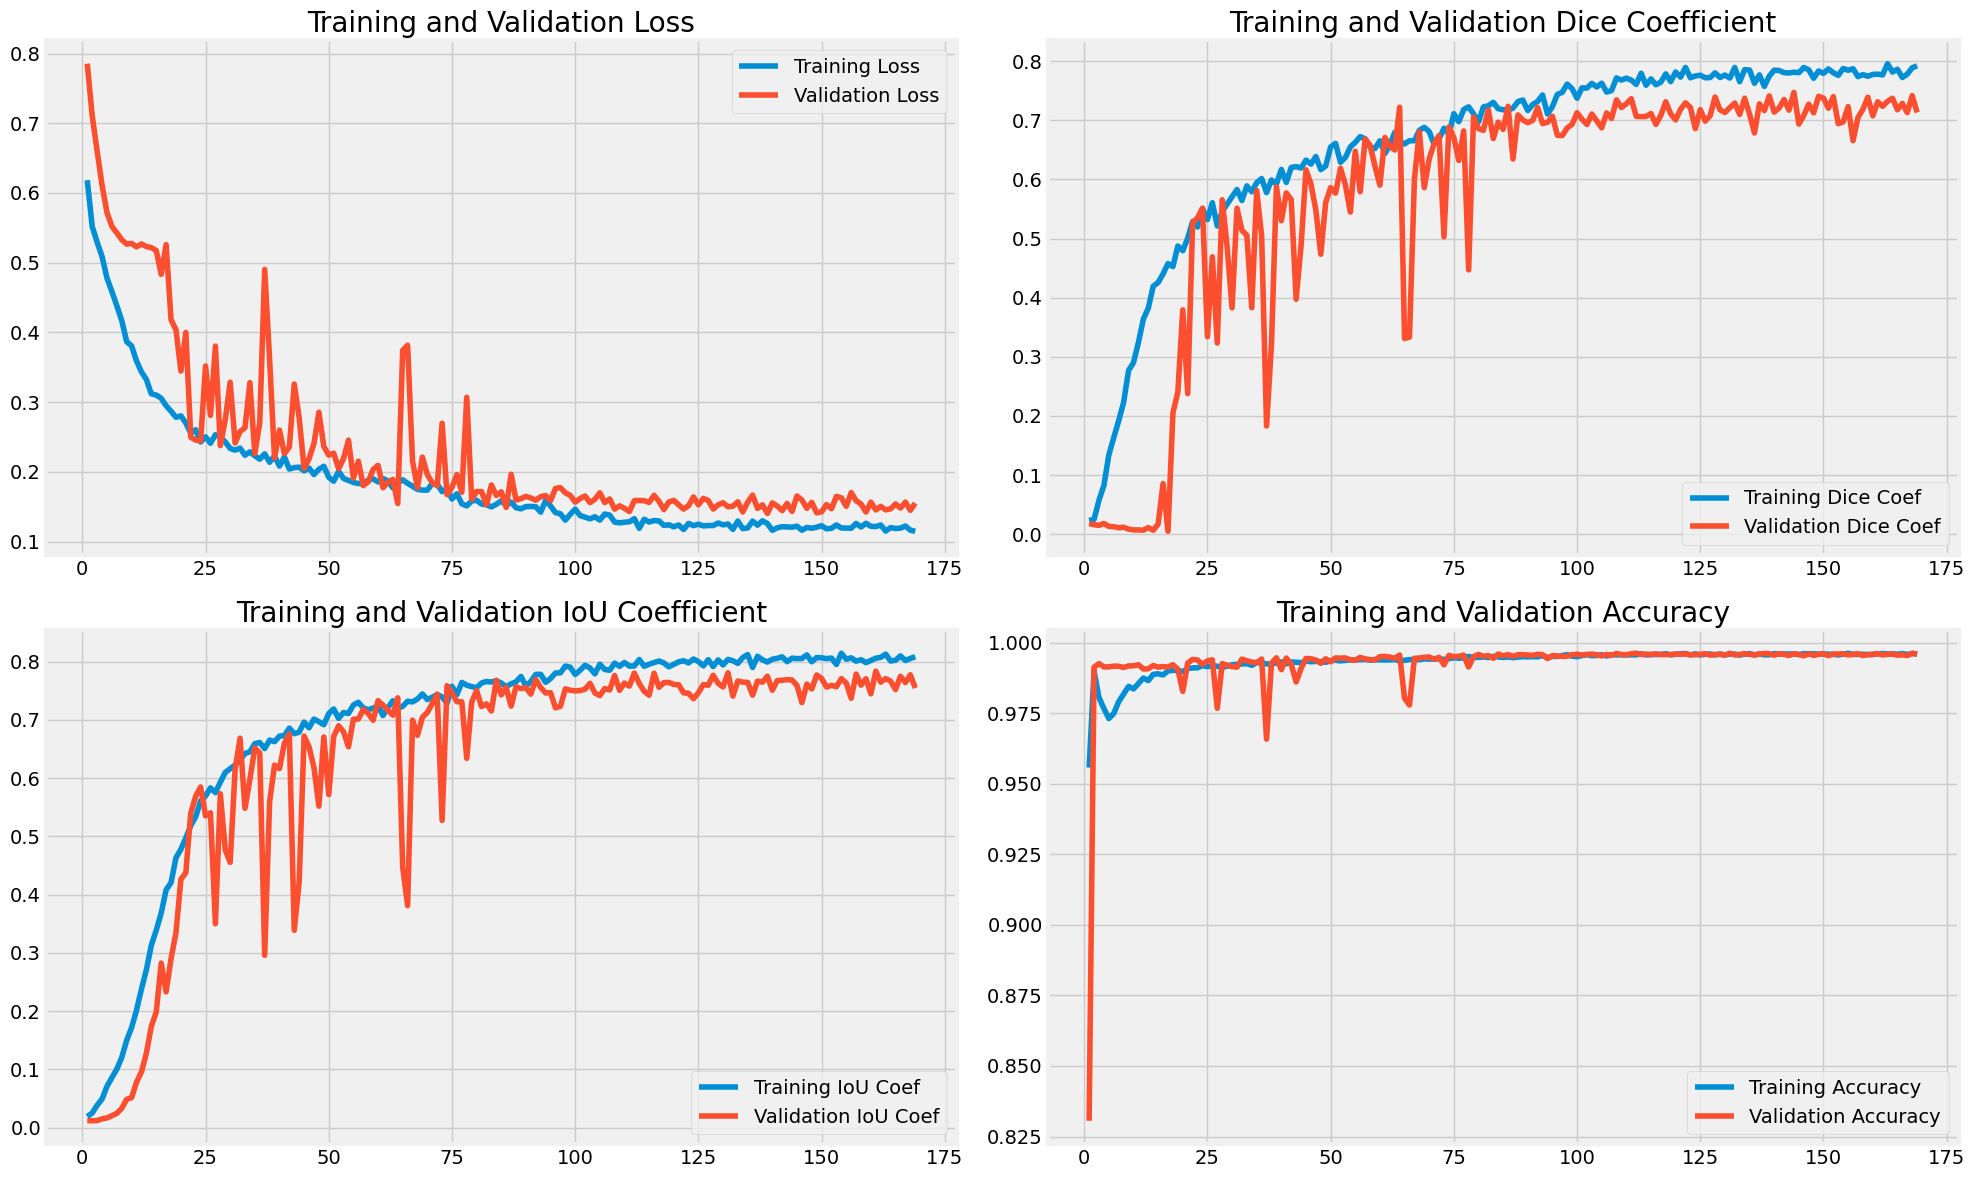

In [ ]:
# ==============================================================================
#                       Eğitim Sonuçlarını Görselleştirme
# ==============================================================================

# 7. EĞİTİM SONUÇLARINI GÖRSELLEŞTİRME
print("\nEğitim geçmişi grafiği çiziliyor...")
if 'history' in locals() and history is not None:
    plot_training(history)
else:
    print("Eğitim geçmişi (history) objesi bulunamadı veya boş.")

## Model değerlendirme kısmını ayırma

### Subtask:
Test verisi üzerinde model değerlendirme adımlarını ayrı bir hücreye taşıyın.


**Reasoning**:
Move the code block for evaluating the model on the test data into a new cell with an appropriate title.



In [ ]:
# ==============================================================================
#                          Model Değerlendirme
# ==============================================================================

# 8. MODEL DEĞERLME
print("\nEn iyi model test verisi üzerinde değerlendiriliyor...")
if not test_df.empty:
    # En iyi ağırlıkları yükle (restore_best_weights=True bunu zaten yapar ama garantiye alalım)
    model.load_weights('unet_best.h5')

    test_gen_eval = create_gens(test_df, aug_dict={}, batch_size=batch_size)
    test_steps_eval = max(1, len(test_df) // batch_size)

    test_score = model.evaluate(test_gen_eval, steps=test_steps_eval, verbose=1)

    print("\n--- TEST SONUÇLARI ---")
    print(f"Test Loss: {test_score[0]:.4f}")
    print(f"Test Accuracy: {test_score[1]:.4f}")
    print(f"Test IoU: {test_score[2]:.4f}")
    print(f"Test Dice: {test_score[3]:.4f}")
else:
    print("Test veriseti boş, değerlendirme atlanıyor.")


En iyi model test verisi üzerinde değerlendiriliyor...
Found 226 validated image filenames.
Found 226 validated image filenames.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.9942 - dice_coef: 0.7216 - iou_coef: 0.7466 - loss: 0.1549

--- TEST SONUÇLARI ---
Test Loss: 0.1617
Test Accuracy: 0.9940
Test IoU: 0.7305
Test Dice: 0.7097


eski

In [ ]:
# ==============================================================================
#                       Tahmin ve Görselleştirme
# ==============================================================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random


# --- BİRLEŞTİRİLMİŞ KOD ---
print("\nTest verisinden birkaç örnek üzerinde tahmin yapılıyor ve analiz ediliyor...")

# 1. Koddan gelen güvenlik kontrolleri
if 'test_df' in locals() and not test_df.empty:
    if 'model' in locals() and model is not None:

        # Döngü, test seti boyutunu aşmayacak şekilde daha güvenli hale getirildi.
        # Sabit 100 yerine min(100, len(test_df)) kullanmak daha iyidir.
        for _ in range(10): # 100, range(min(100,len(test_df))   len(test_df)

            # --- 2. Koddan gelen detaylı analiz ve görselleştirme mantığı ---
            # Bu blok 'for' döngüsünün içinde olmalı (girintiye dikkat)

            index = np.random.randint(0, len(test_df.index))

            img_path = test_df['images_paths'].iloc[index]
            mask_path = test_df['masks_paths'].iloc[index]

            # Tek kanallı okuma ve şekillendirme
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (256, 256))
            img_input = img_resized / 255.0
            img_input = img_input[np.newaxis, :, :, np.newaxis]  # (1, 256, 256, 1)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask_resized = cv2.resize(mask, (256, 256))
            mask_norm = mask_resized / 255.0
            mask_bin = (mask_norm > 0.5).astype(np.float32)

            predicted_img = model.predict(img_input, verbose=0)
            pred_mask = np.squeeze(predicted_img)
            pred_bin = (pred_mask > 0.5).astype(np.float32)


            # Dice ve IoU hesapla
            dice = dice_coef(mask_bin, pred_bin)
            iou = iou_coef(mask_bin, pred_bin)
            threshold = 0.3
            dice_acc = dice > threshold
            iou_acc = iou > threshold

            # Maske ve tahminin üst üste bindirilmesi (farklı renklerde)
            overlay = np.zeros((256, 256, 3), dtype=np.uint8)
            # Gerçek maske (FP+TP) - Kırmızı
            overlay[mask_bin == 1] = [255, 0, 0]
            # Tahmin maskesi (FN+TP) - Yeşil
            overlay[pred_bin == 1] = [0, 255, 0]
            # Kesişim (Doğru Pozitif - TP) - Sarı
            overlay[(mask_bin == 1) & (pred_bin == 1)] = [255, 255, 0]

            ######################### maP ################################################################
            map_score = compute_segmentation_map(mask_bin, pred_mask)
            #print("mAP:", map_score)
            ##############################################################################################

            # Sadece tahmin edilen maskenin renklendirilmiş hali
            predicted_colored = np.zeros((256, 256, 3), dtype=np.uint8)
            predicted_colored[pred_bin == 1] = [0, 255, 0] # Yeşil
            if (1 > dice > threshold or 1 > iou > threshold):
              # Görselleştirme
              plt.figure(figsize=(18, 6))

              plt.subplot(1, 3, 1)
              # RGB görseli doğru renklerde göster
              plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
              plt.axis('off')
              plt.title(f'Orjinal Resim\n({os.path.basename(img_path)})')

              plt.subplot(1, 3, 2)
              plt.imshow(overlay)
              plt.axis('off')
              plt.title('Maske Karşılaştırması\nSarı = Doğru Tahmin (TP)')

              plt.subplot(1, 3, 3)
              plt.imshow(predicted_colored)
              plt.axis('off')
              plt.title(f'maP : {map_score}\nDice: {dice:.3f} (Başarılı: {dice_acc})\nIoU: {iou:.3f} (Başarılı: {iou_acc})')

              plt.tight_layout()
              plt.show()
    else:
        print("Model objesi bulunamadı veya boş.")
else:
    print("Test veriseti boş, tahmin atlanıyor.")


Test verisinden birkaç örnek üzerinde tahmin yapılıyor ve analiz ediliyor...


## Final modeli kaydetme kısmını ayırma

### Subtask:
Eğitilmiş modeli kaydetme adımlarını ayrı bir hücreye taşıyın.


**Reasoning**:
Move the final model saving steps to a new code cell with the specified title.



In [ ]:
# ==============================================================================
#                           Final Modeli Kaydetme
# ==============================================================================

# 10. FİNAL MODELİ KAYDETME
final_model_path = 'unet_final_yualse_colab.h5'
print(f"\nFinal modeli '{final_model_path}' olarak kaydediliyor...")
if 'model' in locals() and model is not None:
    save_model(model, final_model_path)
    print("Modeller başarıyla kaydedildi: 'unet_best_yualse_colab.h5' (eğitimdeki en iyi) ve 'unet_final_yualse_colab.h5' (son hali).")
else:
    print("Model objesi bulunamadı veya boş. Kaydetme işlemi atlanıyor.")

print("\n--- Script Tamamlandı ---")

## Summary:

### Data Analysis Key Findings

*   The process successfully identified and separated different logical sections of the provided Python script (library/helper function definitions, data loading/preparation, data splitting/generator creation, model definition/compilation, callback definition, model training, results visualization, model evaluation, prediction/visualization, and final model saving) into individual code cells.
*   Dependencies between cells (e.g., the need for `df`, `train_df`, `valid_df`, `test_df`, `model`, `history`, `batch_size`, `learning_rate`) were highlighted as execution progressed.
*   The data loading/preparation step failed due to the required zip file not being present, which prevented the creation of the necessary DataFrames (`df`, `train_df`, `valid_df`, `test_df`).
*   Subsequent steps that depended on these DataFrames (data splitting/generator creation, model evaluation, prediction/visualization) were unable to execute fully or failed with `NameError` because the required variables were not defined.
*   The model definition/compilation and final model saving steps were successfully isolated and executed, as they did not directly depend on the DataFrames from the failed data loading step (though training would require the data).
*   The training visualization step was also successfully isolated and executed, but reported that the `history` object was not found (as training didn't run).

### Insights or Next Steps

*   To enable the full execution of the refactored script, the user needs to ensure the `inme_t_f.zip` file is uploaded and correctly processed in the data loading/preparation cell.
*   The refactored structure allows for easier debugging and modification of specific parts of the workflow (e.g., changing the model architecture, adjusting callbacks, or altering data augmentation).
